In [ ]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import pandas as pd

In [ ]:
from cooc import *
from pickle_vocab import *
from preprocessing import pre_process
from helpers import *

In [ ]:
full_train=load_data()

In [ ]:
full_train.sample(5)

## Data pre-processing

In [5]:
full_train.data=pre_process(full_train.data)
full_train.sample(15)

,data,target
113093,03x34 custom picture frame / poster frame 1 26...,:(
113169,bullet proof i wish i was : the lighting & sta...,:(
148594,convert by columbia medium ( 10 - 12 ) - flax ...,:(
180545,no gas lemme see how much i make this weekend,:(
158773,been to three pharmacists for that stuff and a...,:(
6389,last day of classes,:)
199369,sooo annoyin when people get annoyed when i mu...,:(
67004,rt hakuna matata ! what a wonderful phrase,:)
196194,# 9 regular envelope - 24 # white - blue insid...,:(
188939,white - omicron kitchen padded bar stool ( set...,:(


# Data exploration

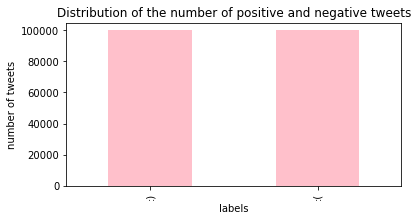

In [10]:
full_train['target'].value_counts().plot.bar(color = 'pink', figsize = (6, 3))
plt.title("Distribution of the number of positive and negative tweets")
plt.ylabel("number of tweets")
plt.xlabel("labels")
plt.show()

The number of tweets per label (positive or negative) is the same. 

In [11]:
full_train.groupby('target').describe()

data                                                           
         count unique                                           top  freq
target                                                                   
:(      100000  91039    i just wrote this ( tell me what you think   335
:)      100000  90111  i love our fans ! there all so beautiful ! x  1536

As already stated above, there is the same number of positive and negative tweets (100'000). In both sets, we have some duplicated tweets as the number of unique tweets for **:(** and for **:)** labels is inferior to 100'000 and it seems that there are more duplicates for the **:)** label. Moreover, the two tweets (one per label) that are the most frequent, have frequency of 335 for **:(** and 1536 for **:)**.  

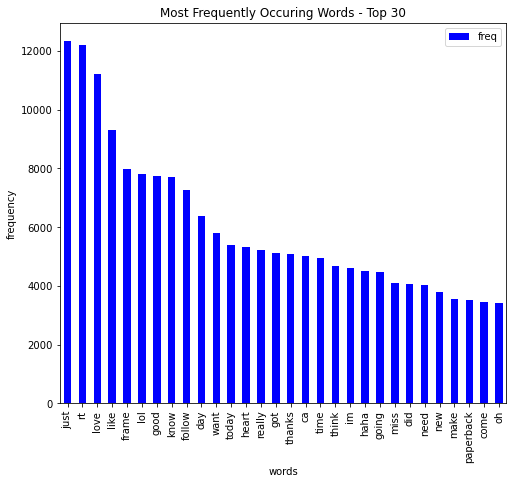

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

##Let's have a look at the words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(full_train.data)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(8, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")
plt.xlabel('words')
plt.ylabel('frequency')
plt.show()

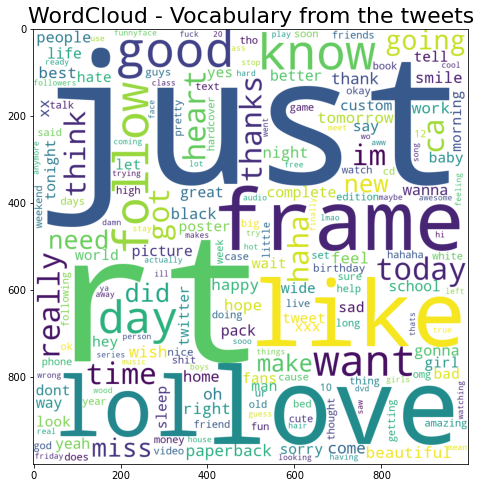

In [13]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from the tweets", fontsize = 22)
plt.show()

#### Split the data

In [6]:
from sklearn.model_selection import train_test_split

train , test=train_test_split(full_train)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

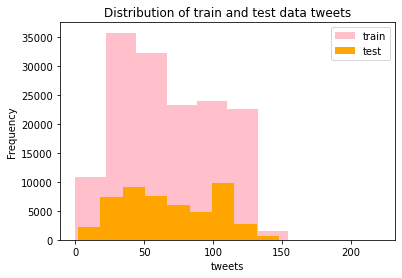

In [15]:
length_train = train['data'].str.len().plot.hist( color = 'pink', figsize = (6, 4), label="train")
length_test = test['data'].str.len().plot.hist(test, color = 'orange', figsize = (6, 4), label="test")
plt.legend(loc='upper right')
plt.xlabel("tweets")
plt.title("Distribution of train and test data tweets")
plt.show()

### Trying models Alex (doesn't work because of float)


In [18]:
maxs = []
for elem in train:
    maxs.append(len(elem.split(" ")))
max_ = max(maxs)

In [99]:
def create_sequences(max_, train, test):
    # fit train words to tokenizer
    tokenizer.fit_on_texts(train)
    # get words and their indexes
    word_index = tokenizer.word_index
    # number of words
    nb_word = len(word_index)
    print(nb_word)
    # transform text to sequence
    X_sequences = tokenizer.texts_to_sequences(train)
    test_sequences = tokenizer.texts_to_sequences(test)
    
    # Pad sequences
    X_sequences = sequence.pad_sequences(X_sequences, maxlen=30,padding='pre')
    test_sequences = sequence.pad_sequences(test_sequences, maxlen=30,padding='pre')

    # create y, first pos then neg
    train_size = len(train)
    y = np.array(int(train_size/2) * [1] + int(train_size/2) * [0])

    # create indices 
    indices = np.arange(X_sequences.shape[0])
    np.random.shuffle(indices)
    X_sequences = X_sequences[indices]
    y = y[indices]
    print("Sequences created!") 
    return X_sequences, test_sequences, y, nb_word, word_index


X_sequences, test_sequences, y, nb_word, word_index = create_sequences(max_,train, test)

NameError: name 'tokenizer' is not defined

In [20]:
def create_glove_matrix(word_embedding, train, nb_word):
    '''
    This method creates an embedding matrix from a dict passed in argument
    '''
    X_splitted = [x.split() for x in train]

    glove_matrix = np.zeros((nb_word + 1, 200))
    for word, i in word_index.items():
        embedding_vector = word_embedding.get(word.encode())
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            glove_matrix[i] = embedding_vector
    print('Matrix created')
    
    return glove_matrix

In [23]:
glove_matrix = create_glove_matrix(glove_template.row, train ,nb_word)

NameError: name 'glove_template' is not defined

In [63]:
# tokenizing the words present in the training set
tokenized_tweet = train['data'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['data']), epochs=20)

(34440803, 47185960)

In [28]:
#Other way of splitting
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train.data, train.target, test_size = 0.25, random_state = 42)
#train.data, test.data, train.target, test.target
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(112500,)
(37500,)
(112500,)
(37500,)


## Embedding matrix genrated with glove_template 

In [7]:
#loading the embeddings
embedding = np.load('embeddings.npy')
embedding

array([[ 0.14205962,  0.18065308, -0.59707358, ...,  0.11122289,
        -0.3996204 , -0.07684434],
       [ 0.20156825,  0.25765782, -0.74777565, ...,  0.11841265,
        -0.49990884, -0.06274457],
       [ 0.23885284,  0.23563671, -0.88665867, ...,  0.17813218,
        -0.54149148, -0.09626553],
       ...,
       [ 1.02610453,  0.01232929,  0.61215281, ...,  0.55733637,
        -1.02616071,  0.48671472],
       [-1.26676919,  1.17572176, -0.45754138, ..., -1.2803609 ,
        -0.31948779, -0.8750009 ],
       [-1.13319243,  0.76661069, -0.80099514, ..., -0.99269073,
         1.37497309, -1.54028131]])

In [8]:
#Associate embedding with vocab words: 
vocab = pickle.load(open('vocab.pkl', "rb")) #this file was generated by executing vocab.sh
word_embedding = {}
for key in vocab.keys():
    word_embedding[key] = embedding[vocab.get(key)] #keys in this dict are not encoded 

In [9]:
word_embedding_ = pd.DataFrame(word_embedding).T
word_embedding_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
<user>,0.142060,0.180653,-0.597074,0.107424,-0.109419,0.362307,0.388570,0.209220,-0.201623,-0.087574,0.319521,0.339559,0.233919,0.053866,0.134681,-0.312904,-0.204372,0.111223,-0.399620,-0.076844
!,0.201568,0.257658,-0.747776,0.131550,-0.124964,0.488308,0.492275,0.277165,-0.253994,-0.118913,0.386144,0.390608,0.298506,0.055792,0.196397,-0.423093,-0.323860,0.118413,-0.499909,-0.062745
i,0.238853,0.235637,-0.886659,0.137024,-0.136336,0.539398,0.563205,0.299993,-0.309439,-0.151941,0.474274,0.430644,0.320344,0.082772,0.212950,-0.431264,-0.331706,0.178132,-0.541491,-0.096266
the,0.130046,0.164172,-0.539436,0.081422,-0.115358,0.346475,0.323468,0.201023,-0.168746,-0.103513,0.279440,0.244223,0.205507,0.039568,0.160183,-0.288688,-0.172304,0.115245,-0.340737,-0.068904
.,0.161507,0.178203,-0.677781,0.108642,-0.098384,0.413938,0.446160,0.247648,-0.233491,-0.092993,0.384231,0.356973,0.227143,0.048145,0.135391,-0.312342,-0.236935,0.126915,-0.394896,-0.067515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#24,1.227720,0.579513,-2.342988,0.067716,1.887846,0.307757,-1.141217,0.169917,-1.512983,-0.984647,0.295459,0.715269,0.419201,-0.709521,0.834665,0.734758,0.127676,1.132830,-0.058477,-1.381742
#20,0.999332,-2.119324,-1.089696,0.831637,-0.149304,0.697253,-0.836633,0.189492,0.470407,-0.460470,-0.477985,-0.977953,1.029165,-2.403820,-0.075742,0.153101,0.616580,-0.342977,0.441204,-0.574883
#1dsongconcept,1.026105,0.012329,0.612153,-1.269533,-0.760138,0.793649,0.399102,0.859880,-0.298815,0.841978,-1.424659,0.184410,-0.362435,-0.188243,1.008235,-0.096033,-0.800237,0.557336,-1.026161,0.486715
#18,-1.266769,1.175722,-0.457541,-0.646836,-1.019695,2.360475,0.472858,-2.041092,-2.587089,1.101651,-0.799423,0.473816,-2.090640,-0.111123,-0.517042,-1.904858,0.618097,-1.280361,-0.319488,-0.875001


In [10]:
def average_word_vectors(tweets ,word_embedding):
    
    error = 0
    avg_word_vectors = np.zeros((len(tweets), word_embedding.shape[1] ))
    for i, tweet in enumerate(tweets):
        
        split_tweet = tweet.split()
        nb_words = 0
        
        for word in split_tweet:
            try:
                avg_word_vectors[i] += word_embedding.loc[word].to_numpy()
                nb_words += 1

            except KeyError: 
                continue
        if (nb_words != 0):
            avg_word_vectors[i] /= nb_words
        
    return avg_word_vectors

In [11]:
avg_word_vectors = average_word_vectors(train.data ,word_embedding_)
avg_word_vectors_df = pd.DataFrame(avg_word_vectors)
avg_word_vectors_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.243310,0.243964,-0.958928,0.147963,-0.221796,0.571123,0.589611,0.298871,-0.242499,-0.079835,0.546600,0.398215,0.387252,0.173189,0.231131,-0.453181,-0.239570,0.169272,-0.546503,-0.095201
1,0.224890,0.132166,-0.780398,0.001598,-0.059673,0.532429,0.578597,0.243131,-0.246404,-0.121798,0.359076,0.252602,0.345787,0.162717,0.238609,-0.519388,-0.281682,0.205386,-0.484247,0.054618
2,0.188877,0.199574,-0.855750,0.069666,-0.080338,0.448244,0.475486,0.272709,-0.272395,-0.057271,0.662365,0.334981,0.281639,0.244734,0.251842,-0.492269,-0.120263,-0.004921,-0.391773,0.010428
3,0.175661,0.295702,-0.769719,0.130102,-0.320830,0.427388,0.482528,0.183297,-0.091508,-0.298508,0.447959,0.198283,0.178810,0.190310,0.143064,-0.425885,-0.182155,0.201366,-0.530776,-0.070701
4,0.347401,0.111713,-0.522123,0.114729,0.068429,0.475843,0.270254,0.020731,-0.247146,-0.176051,0.338644,0.252248,0.230398,0.094784,0.053325,-0.359659,-0.137497,0.081525,-0.239249,-0.043536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.073016,0.301039,-0.666883,0.210809,-0.275787,0.317121,0.534169,0.289643,-0.244074,-0.149639,0.290811,0.392629,0.320678,-0.032386,0.081975,-0.441659,-0.206935,-0.089077,-0.287781,0.109111
149996,-0.028541,-0.090719,-0.601489,0.803238,-0.536778,-0.304907,0.209953,0.392397,-0.744098,-0.408882,0.385685,0.265451,-0.023002,-0.022491,0.280578,-0.455859,0.370403,-0.009536,-0.489130,-0.156310
149997,0.209509,0.182247,-1.025184,0.145262,0.020939,0.358892,0.493205,0.378083,-0.304725,-0.061974,0.435520,0.306305,0.401239,0.149556,0.272950,-0.555761,-0.399092,0.155762,-0.626337,0.094443
149998,0.079783,0.289723,-0.668925,0.243486,-0.104404,0.555007,0.262438,0.351708,-0.407464,-0.166646,0.501246,0.467704,0.120277,0.003980,0.294913,-0.350529,-0.142390,0.121966,-0.580684,0.006874


In [12]:
#Associate tweets with the average word vectors of each tweet
sample_train_word_vectors= train.join(avg_word_vectors_df)
sample_train_word_vectors

,index,data,target,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,20127,look on my facebook there a picture with me we...,:),0.243310,0.243964,-0.958928,0.147963,-0.221796,0.571123,0.589611,...,0.546600,0.398215,0.387252,0.173189,0.231131,-0.453181,-0.239570,0.169272,-0.546503,-0.095201
1,196314,""" so did marlin and dory end up together "" i a...",:(,0.224890,0.132166,-0.780398,0.001598,-0.059673,0.532429,0.578597,...,0.359076,0.252602,0.345787,0.162717,0.238609,-0.519388,-0.281682,0.205386,-0.484247,0.054618
2,29135,ouch i will try to steer clear of you then,:),0.188877,0.199574,-0.855750,0.069666,-0.080338,0.448244,0.475486,...,0.662365,0.334981,0.281639,0.244734,0.251842,-0.492269,-0.120263,-0.004921,-0.391773,0.010428
3,27126,goodnights hehe take care ! !,:),0.175661,0.295702,-0.769719,0.130102,-0.320830,0.427388,0.482528,...,0.447959,0.198283,0.178810,0.190310,0.143064,-0.425885,-0.182155,0.201366,-0.530776,-0.070701
4,102419,stonehenge ( mass market paperback discover a ...,:(,0.347401,0.111713,-0.522123,0.114729,0.068429,0.475843,0.270254,...,0.338644,0.252248,0.230398,0.094784,0.053325,-0.359659,-0.137497,0.081525,-0.239249,-0.043536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,162549,post extraction and chemical peel face = i loo...,:(,0.073016,0.301039,-0.666883,0.210809,-0.275787,0.317121,0.534169,...,0.290811,0.392629,0.320678,-0.032386,0.081975,-0.441659,-0.206935,-0.089077,-0.287781,0.109111
149996,188900,what wrong poorly child,:(,-0.028541,-0.090719,-0.601489,0.803238,-0.536778,-0.304907,0.209953,...,0.385685,0.265451,-0.023002,-0.022491,0.280578,-0.455859,0.370403,-0.009536,-0.489130,-0.156310
149997,123820,you ca not blow a hologram rt just now seeing ...,:(,0.209509,0.182247,-1.025184,0.145262,0.020939,0.358892,0.493205,...,0.435520,0.306305,0.401239,0.149556,0.272950,-0.555761,-0.399092,0.155762,-0.626337,0.094443
149998,24250,i love the film prom night,:),0.079783,0.289723,-0.668925,0.243486,-0.104404,0.555007,0.262438,...,0.501246,0.467704,0.120277,0.003980,0.294913,-0.350529,-0.142390,0.121966,-0.580684,0.006874


In [13]:
X_train = sample_train_word_vectors.drop(columns=["data","target","index"])

In [14]:
Y_train = sample_train_word_vectors.target


In [15]:
avg_word_vectors_test_df = pd.DataFrame(average_word_vectors(test.data ,word_embedding_))

In [16]:
sample_test_word_vectors=test.join(avg_word_vectors_test_df)
X_test = sample_test_word_vectors.drop(columns=["data","target", "index"])
Y_test = sample_test_word_vectors.target

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

# define model model
model = SVC(cache_size=1000, kernel='poly')
# define test harness
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
m_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(m_scores), std(m_scores)))

### Training models with glove 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [32]:
#Logistic Regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, Y_train))
print("Validation Accuracy :", model.score(X_test, Y_test))

# confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Accuracy : 0.5993933333333333
Validation Accuracy : 0.59696
[[13213 11737]
 [ 8415 16635]]


In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf_svm = Pipeline([('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(X_train, Y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == Y_test)

0.6011

In [34]:
from sklearn.svm import SVC

clf = SVC(cache_size=1000)
clf.fit(X_train, Y_train)

SVC(cache_size=1000)

In [36]:
pred=clf.predict(X_test)

In [37]:
np.mean(pred == Y_test)

0.63108

In [23]:
#convert smiley to +1, -1
Y_train_tr=transform_smiley(Y_train)
Y_test_tr= transform_smiley(Y_test)

In [73]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, Y_train_tr)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, Y_train_tr))
print("Validation Accuracy :", model.score(X_test, Y_test_tr))

Training Accuracy : 0.9980133333333333
Validation Accuracy : 0.64034


### Create submission

In [63]:
with open('twitter-datasets/test_data.txt') as f:
    real_test = f.readlines()
real_test={'data':real_test}
real_test=pd.DataFrame(real_test)

**test data pre-processing:**

In [65]:
real_test.data=pre_process(real_test.data)
real_test.sample(15)

,data
2211,2212 tv cable white 50ft rg59 ( gold plated tv...
6411,6412 i miss my longgg phone charger cord ( it ...
626,627 dsm iv : diagnostic and statistical manual...
403,404 watching lost i love this class so much
5245,5246 mckennas part but all of them are awesome...
9815,9816 man i wanted to go to school today
8520,8521 who wants to speak to phone lines are gon...
6350,6351 sometimes rest is best
3823,3824 i want to be followed by because he is su...
9178,9179 i wish i got one of the tapes of it


In [69]:
import re
ids=[]   
for i in range (len(real_test)):
    text=real_test.data[i]
    found=re.findall('\d+', text )
    ids.append(found[0])


In [ ]:
OUTPUT_PATH = 'sample_submission.csv' # TODO: fill in desired name of output file for submission
#weights, loss=ridge_regression(y_train, x_train, best_lambda)
#y_pred = text_clf_svm.predict(real_test)
create_csv_submission(ids, y_pred, OUTPUT_PATH)

In [19]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [25]:
Y_test_tr = np.array(Y_test_tr)
Y_train_tr = np.array(Y_train_tr)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
history = model.fit(X_train, Y_train_tr,
                     epochs=100,
                     verbose=False,
                     validation_data=(X_test, Y_test_tr),
                    batch_size=10)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))